In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

X, Y, Z indicate $\pi/2$ pulses about those axes. P indicates $\pi$ pulse about X axis. ge/ef indicate frequency with which it's resonant.

Each measurement gives one of g, e, or f for each qubit -> 9 different measurement outcomes.

In [3]:
meas_order_1Q = ['I', 'Xge', 'Yge', 'Xef', 'Yef', 'Pge', 'PgeXef', 'PgeYef']
meas_order_1Q = np.array(meas_order_1Q)
meas_order = []
for meas1 in meas_order_1Q:
    for meas2 in meas_order_1Q:
        meas_order.append((meas1, meas2))
meas_order = np.array(meas_order) # 8x8 = 64 measurements

calib_order_1Q = ['g', 'e', 'f']
calib_order = []
for calib1 in calib_order_1Q:
    for calib2 in calib_order_1Q:
        calib_order.append((calib1, calib2))
calib_order = np.array(calib_order)

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

$\ket{\psi}=\cos(\theta/2)\ket{0}+e^{i\phi}\sin(\theta/2)\ket{1}$

On Bloch sphere, pointing towards:

$\pm X=\frac{1}{\sqrt{2}}(\ket{0}\pm\ket{1})$

$\pm Y=\frac{1}{\sqrt{2}}(\ket{0}\pm i\ket{1})$

In [4]:
"""
Define basis in to be used when doing MLE
Pge = pi pulse about X axis, X/Yge/ef indicate pi/2 pulses around those axes.
After pulse, what state were you in if you measure exactly g, e, or f?
See mathematica nb for pauli rotations
"""
# 8 measurements x 3 "cardinal points" on Bloch sphere for each measurement axis
rt2 = np.sqrt(2)
I = [qt.basis(3,0), qt.basis(3,1), qt.basis(3,2)]
Xge = [(I[0]+1j*I[1])/rt2, (1j*I[0]+I[1])/rt2, I[2]]
Yge = [(I[0]-I[1])/rt2, (I[0]+I[1])/rt2, I[2]]
Xef = [I[0], (I[1]+1j*I[2])/rt2, (1j*I[1]+I[2])/rt2]
Yef = [I[0], (I[1]-I[2])/rt2, (I[1]+I[2])/rt2]
Pge = [1j*I[1], 1j*I[0], I[2]]
PgeXef = [1j*I[1], (1j*I[0]+1j*I[2])/rt2, (-I[0]+I[2])/rt2]
PgeYef = [1j*I[1], (1j*I[0]-I[2])/rt2, (1j*I[0]+I[2])/rt2]
psi = dict(I=I, Xge=Xge, Yge=Yge, Xef=Xef, Yef=Yef, Pge=Pge, PgeXef=PgeXef, PgeYef=PgeYef)

psi_basis = [] # ordered in the same sequence as the n counts array (64 x 9 elements)
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi[S1]
    psi2 = psi[S2]
    # append for each of the possible measurement outcomes for the 2 qubits: g, e, f
    for state1 in range(3):
        for state2 in range(3):
            psi_basis.append(qt.tensor(psi1[state1], psi2[state2]))
# print(len(psi_basis))

### Generate test data

In [5]:
"""
Provide ideal rho, total counts
"""
def generate_counts(rho_id, n_tot, noise=1.0):
    n = []
    for psi in psi_basis:
        # measure in psi basis
        n.append(n_tot * (psi * psi.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis)//len(calib_order), len(calib_order)))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n_last = -1
        while new_n_last < 0:
            new_n_all_but_last = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
            # preserve original total count per measurement
            new_n_last = n_meas - sum(new_n_all_but_last)
        n_psi[:-1] = np.round(new_n_all_but_last)
        n_psi[-1] = np.round(new_n_last)
    return n
# psi_id = qt.tensor(I[2], I[0])
# rho_id = qt.ket2dm(psi_id)
# generate_counts(rho_id, 500)

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [6]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [7]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [8]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    assert(len(t)==81)
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

# psi_id = qt.tensor(I[2], I[0])
# rho_id = qt.ket2dm(psi_id)
# print(rho_id)
# print(rho_from_t(t_from_rho(rho_id)))

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution matrices" to match the MLE.

Note: uses QSwitch and related classes

In [9]:
"""
Convert dac units to drive strength in GHz
"""
def gain_to_freq(dac_units):
    # raise NotImplementedError
    return dac_units/32000
    
def get_evoln_mats(qfreqs, alphas, gs, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evoln_mats = dict()
    for pulse, pulse_cfg in tqdm(pulse_dict.items()):
        # print(pulse)
        device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[2,2], is2Q=True)
        seq = PulseSequence()
        q0_params = pulse_cfg['qubit0'].copy()
        q1_params = pulse_cfg['qubit1'].copy()

        t_offset = 0
        for params in (q0_params, q1_params):
            params['freq'] = soc.reg2freq(params['freq'], gen_ch=params['ch']) * 1e-3
            params['gain'] = gain_to_freq(params['gain'])
            params['phase'] = soc.reg2deg(params['phase']) * np.pi/180
            type = params['type']
            total_length = 0
            if type == 'const':
                params['length'] = soc.cycles2us(params['length']) * 1e3
                total_length = params['length']
            elif type == 'gauss': 
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                total_length = 4*params['sigma']
            elif type == 'flat_top':
                raise NotImplementedError
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                params['flat_length'] = soc.cycles2us(params['flat_length']) * 1e3
                total_length = None
            device.add_precise_pi_pulse(seq, 'gg', 'ee', amp=params['gain'], drive_qubit=1, wd=params['freq'], phase=params['phase'], type=type, t_offset=t_offset, t_pulse=total_length)
            # t_offset = -total_length # play the pulses on the two qubits at the same time
        pulse_index = np.where(np.array(meas_order)==str(pulse))[0][0]
        psi0 = psi_basis[pulse_index]
        times = np.linspace(0, total_length+10)
        evoln_mats.update({pulse:device.evolve(psi0, seq, times, nsteps=10000, use_str_solve=False, progress=False)[-1]})
    evoln_mats_in_meas_order = []
    for pulse in meas_order: evoln_mats_in_meas_order.append(evoln_mats[pulse])
    return evoln_mats_in_meas_order

### MLE functions

In [10]:
def run_MLE_standard(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = qt.tensor(qt.qeye(3), qt.qeye(3))
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [11]:
def run_MLE_ZZ(n, evol_matrices, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = qt.tensor(qt.qeye(3), qt.qeye(3))
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(evol_matrices, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [12]:
def run_MLE(n, ZZ_correction=False, evol_matrices=None, rho_guess=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_matrices, rho_guess=rho_guess, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, method=method)

# Run experiment and analysis

In [13]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.twoqutrit_state_tomography
imp

In [14]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [15]:
# expt_path = os.getcwd()+'\data'
expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\20220430_2Transmon\data


In [16]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\220623_qram\config_q3diamond.yml


In [17]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [18]:
qubits = [0, 1] # which qubit/resonator we want to probe

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [19]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg.hw.lo.readout.frequency)) # Set LO frequency
lo1.set_power(float(yaml_cfg.hw.lo.readout.power)) # Set LO power

0

In [20]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

## Run experiment and acquire data

In [21]:
tomo = meas.EgGfStateTomographyQutritExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_qutrit_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=1000, # reps per measurement basis
    shot_avg=10, # number of shots to average over before sorting via threshold
    qubits=qubits,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 44], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'f_ef': [658, 3377, -55, 293], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [1000, 1000, 1000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [100, 250, 150, 150]}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'ful

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

freq 600.9
freq -665.3
freq -292.1
freq -130.4


RuntimeError: frequency collision: 854.600001 and 871.699999 MHz both map to the PFB channel that is optimal for [844.800000, 998.400000] (all freqs expressed in first Nyquist zone)

In [105]:
# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
Tomography counts
[[ 37  85 333 545]
 [102  33 647 218]
 [107  30 672 191]
 [ 78  86 401 435]
 [106  48 637 209]
 [106  40 604 250]
 [ 46  91 373 490]
 [ 86  41 610 263]
 [132  39 641 188]]
Confusion matrix counts
[[715 109 151  25]
 [329 522  64  85]
 [ 96  22 791  91]
 [ 59  67 393 481]]
Corrected tomo matrix will be
[[ -36.66574   28.13011 -149.79473 1158.33036]
 [  34.71227  -13.85713  647.84264  331.30222]
 [  38.90501  -14.41898  712.74162  262.77235]
 [   5.89261   47.43464   62.89449  883.77826]
 [  27.15411   19.60369  645.78118  307.46101]
 [  44.38218   -9.07821  549.63255  415.06347]
 [ -40.09262   53.43585  -30.45734 1017.11411]
 [  11.79775   -3.91938  549.15975  442.96188]
 [  74.72804   -2.52197  666.46849  261.32543]]


## Run analysis

Generate test data

In [106]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=1000, noise=1)
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [90]:
psi_id = qt.tensor(psiZ[0], 1/np.sqrt(2)*(psiZ[0]+psiZ[1]))
# psi_id = qt.tensor(psiZ[1], psiZ[1])
rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]


In [143]:
t = t_from_rho(rho_id)
print(t)
T = T_flat2mat(t)
print(T.conjugate().transpose() @ T / np.trace(T.conjugate().transpose() @ T))

print('cholesky')
t = t_from_rho(rho_id)
print(t)
T = T_flat2mat(t)
print(T @ T.conjugate().transpose()) # / np.trace(T @ T.conjugate().transpose()))

[0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
cholesky
[0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[[0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


 <ipython-input-142-af68c462c7ba>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-142-af68c462c7ba>: 14

##### Run MLE without ZZ correction

In [107]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(correct_readout_err(n_tomo, n_calib), ZZ_correction=False, method='L-BFGS-B')
if rho_MLE_base is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')

Convergence: True
Fidelity (no ZZ correction): 0.11363475328326939
Purity (no ZZ correction): 0.9219017391226487


In [108]:
print(np.around(rho_MLE_base, decimals=3))

[[ 0.017+0.j     0.016-0.009j -0.027+0.013j -0.008+0.036j]
 [ 0.016+0.009j  0.178+0.j    -0.096-0.013j -0.246+0.262j]
 [-0.027-0.013j -0.096+0.013j  0.08 +0.j     0.113-0.158j]
 [-0.008-0.036j -0.246-0.262j  0.113+0.158j  0.725+0.j   ]]


#### Run MLE with ZZ

Get evoln matrices for ZZ

In [109]:
qfreqs = np.array(yaml_cfg.device.qubit.f_ge) # MHz
alphas = np.array(yaml_cfg.device.qubit.f_ef) - qfreqs # MHz
g = 25 # MHz
evol_matrices = get_evoln_mats(qfreqs=qfreqs*1e-3, alphas=alphas*1e-3, gs=g*1e-3, pulse_dict=pulse_dict)

100%|██████████| 9/9 [00:00<00:00, 30.51it/s]


In [110]:
rho_MLE_ZZ = run_MLE(correct_readout_err(n_tomo, n_calib), rho_guess=None, ZZ_correction=True, evol_matrices=evol_matrices)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')

Convergence: True
Fidelity (with ZZ correction): 0.06207295277287382
Purity (with ZZ correction): 0.8081454196391508


In [111]:
print(np.around(rho_MLE_ZZ, decimals=3))

[[ 0.027+0.j     0.029+0.j     0.026-0.033j -0.073-0.033j]
 [ 0.029-0.j     0.04 +0.j     0.031-0.049j -0.087-0.05j ]
 [ 0.026+0.033j  0.031+0.049j  0.089+0.j    -0.003-0.141j]
 [-0.073+0.033j -0.087+0.05j  -0.003+0.141j  0.844+0.j   ]]


## Plotting

#### Plotting functions

In [112]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-1, vmax=1)
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

In [113]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

#### Plot!

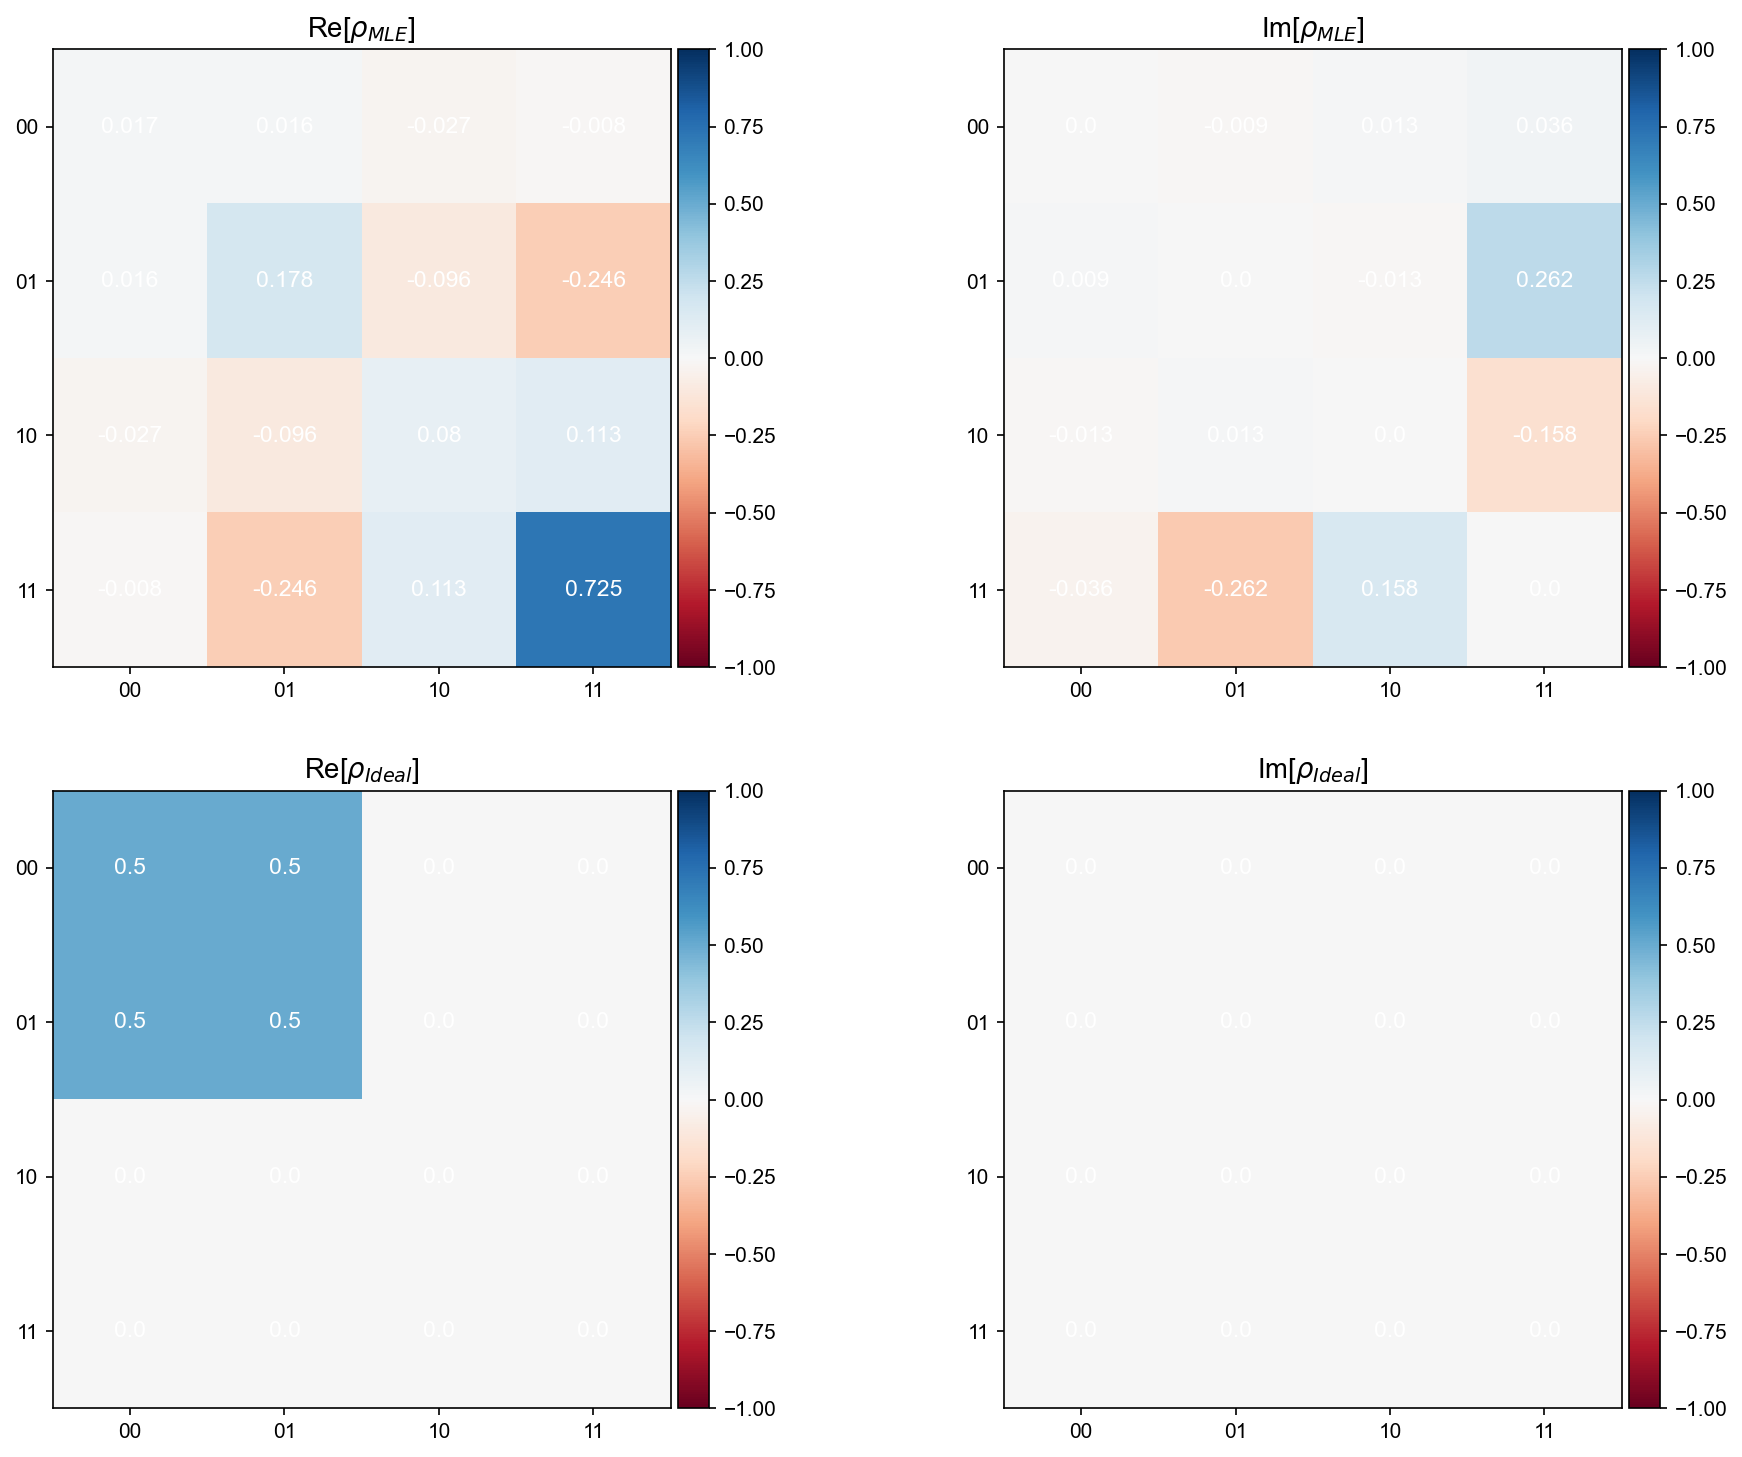

In [114]:
show_plot_rho_2d(rho_MLE_base, rho_id)

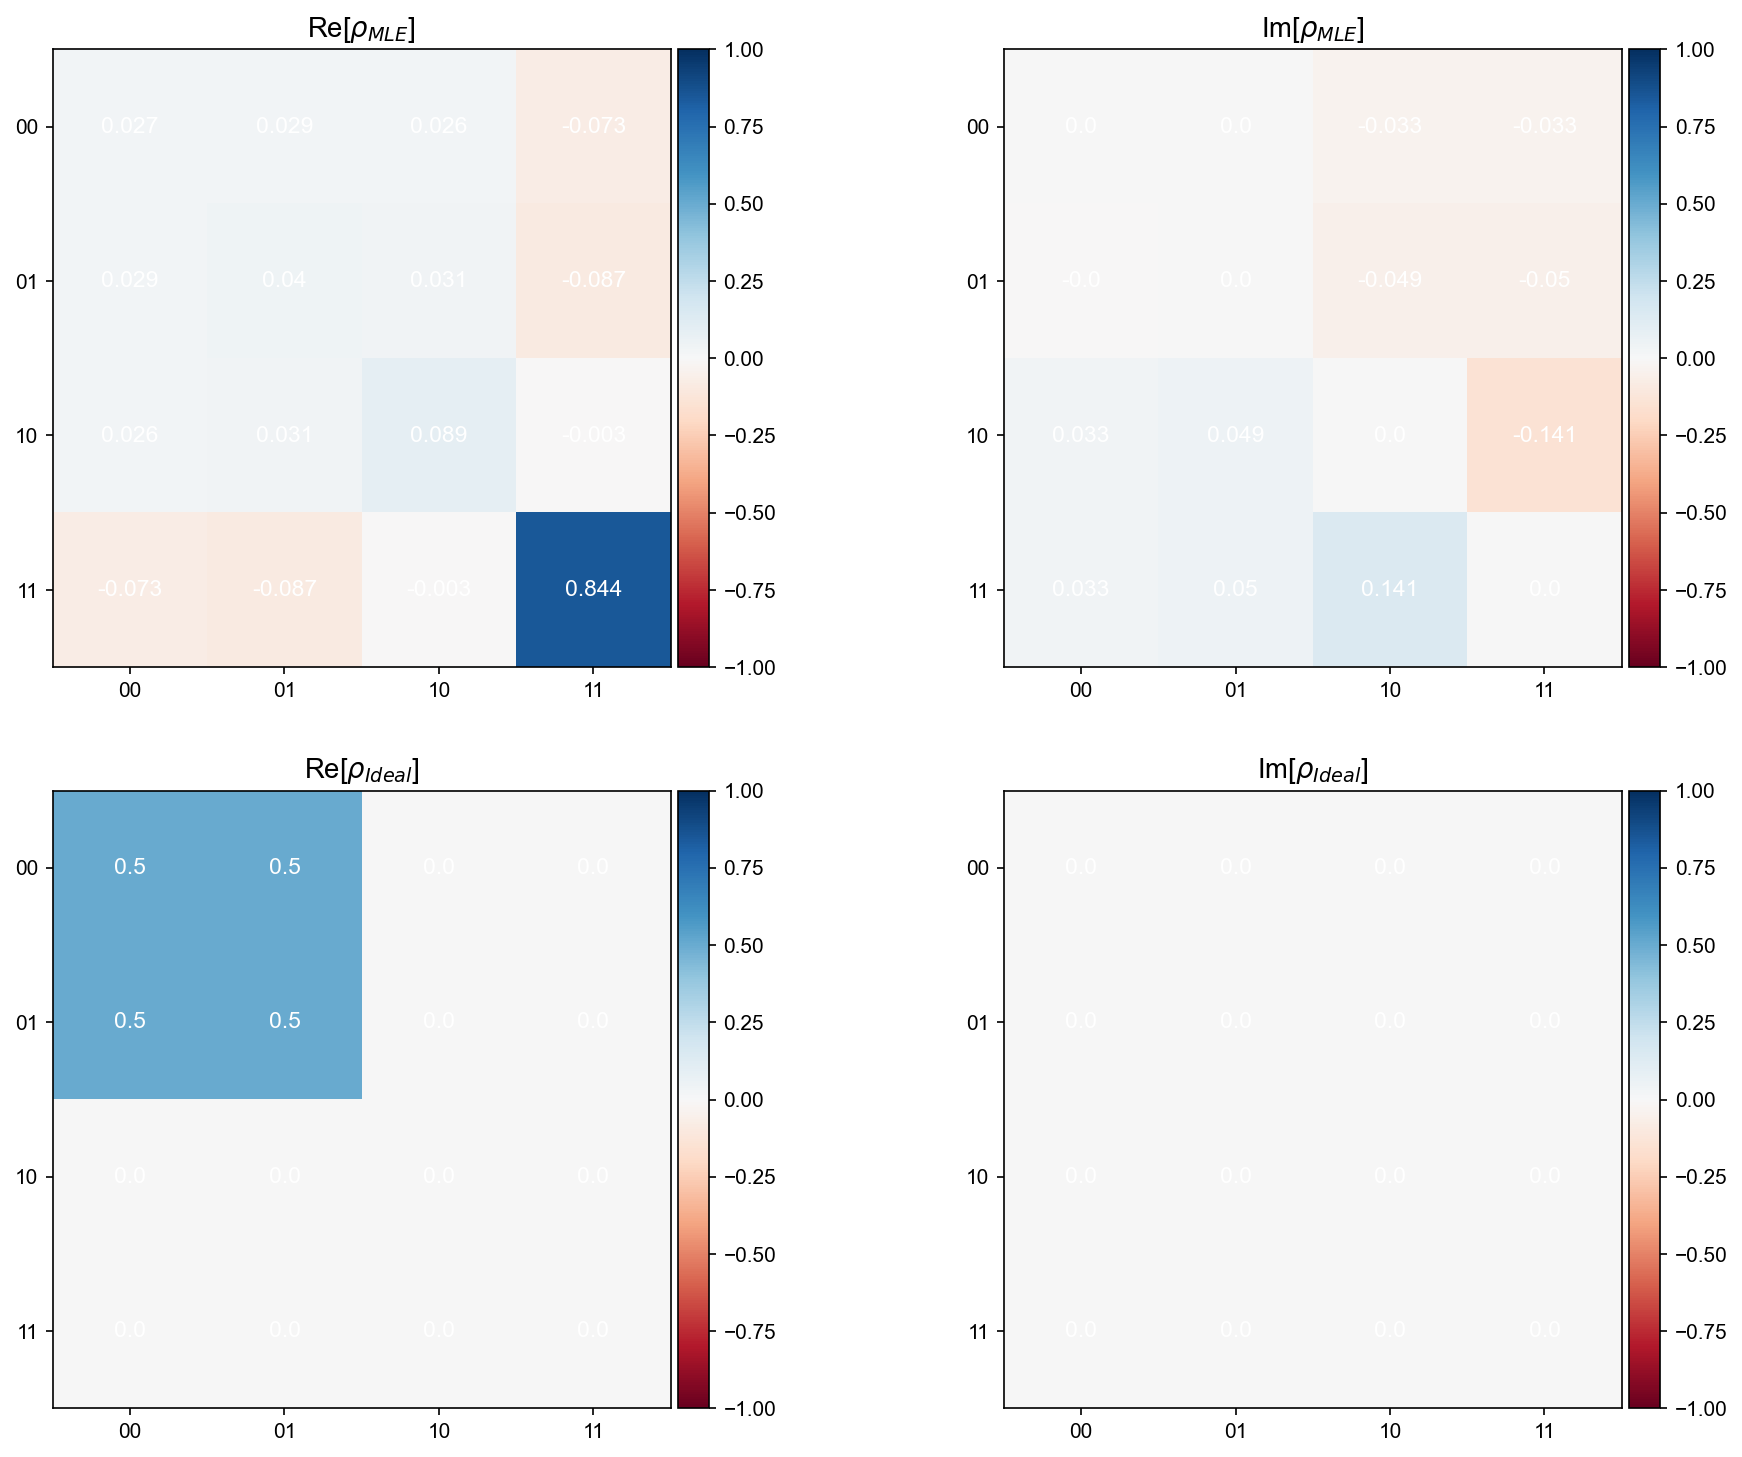

In [115]:
show_plot_rho_2d(rho_MLE_ZZ, rho_id)

In [157]:
tomo.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_EgGf_state_tomo_01.h5
